In [9]:
import sys
sys.path.append('./Files')
import os
import matplotlib.pyplot as plt
import time
import macroC as mC 
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.hamiltonians import QuadraticHamiltonian
from qiskit.quantum_info import Operator, SparsePauliOp
JW = JordanWignerMapper()

In [10]:
# Definimos si va a ser archivo de minimización de H o de free energy, el sistema a estudiar y si es con o sin shots.
spins=7
J=100
shots=None 
method='SLSQP' # 'SLSQP'/'COBYLA'
layers=1
func='FE' # 'H'/'FE'
typetrunc='Trunc4' # 'NoTrunc','Trunc1','Trunc2','Trunc3','Trunc4'



if shots==0:
    shots=None
name=str(spins)+'SpinsCN-J='+str(J)

In [11]:
file ='./Data/'+func+'/'+typetrunc+'/'+name+'-'+method+'-'+'Layers='+str(layers)+'-'+'Shots='+str(shots)+'.dat'

In [12]:
# Creamos la lista vacía de los datos que vamos a leer
data=[i.strip().split() for i in open(file).readlines()]
nbetas=len(data)
betas=[float(data[i][0]) for i in range(nbetas)]
sortindex=np.argsort(betas)
betas=np.sort(betas)
overlaps=[float(data[sortindex[i]][1]) for i in range(nbetas)]
niter=[float(data[sortindex[i]][2]) for i in range(nbetas)]
times=[float(data[sortindex[i]][3]) for i in range(nbetas)]

In [13]:
print(betas)

[1.00000000e-03 2.05061224e-01 4.09122449e-01 6.13183673e-01
 8.17244898e-01 1.02130612e+00 1.22536735e+00 1.42942857e+00
 1.63348980e+00 1.83755102e+00 2.04161224e+00 2.24567347e+00
 2.44973469e+00 2.65379592e+00 2.85785714e+00 3.06191837e+00
 3.26597959e+00 3.47004082e+00 3.67410204e+00 3.87816327e+00
 4.08222449e+00 4.28628571e+00 4.49034694e+00 4.69440816e+00
 4.89846939e+00 5.10253061e+00 5.30659184e+00 5.51065306e+00
 5.71471429e+00 5.91877551e+00 6.12283673e+00 6.32689796e+00
 6.53095918e+00 6.73502041e+00 6.93908163e+00 7.14314286e+00
 7.34720408e+00 7.55126531e+00 7.75532653e+00 7.95938776e+00
 8.16344898e+00 8.36751020e+00 8.57157143e+00 8.77563265e+00
 8.97969388e+00 9.18375510e+00 9.38781633e+00 9.59187755e+00
 9.79593878e+00 1.00000000e+01 1.00000000e+01 1.02040816e+01
 1.04081633e+01 1.06122449e+01 1.08163265e+01 1.10204082e+01
 1.12244898e+01 1.14285714e+01 1.16326531e+01 1.18367347e+01
 1.20408163e+01 1.22448980e+01 1.24489796e+01 1.26530612e+01
 1.28571429e+01 1.306122

In [14]:
# Elegimos el beta que queremos la representación.
indexbeta=4
beta=betas[indexbeta]
print(beta)

0.8172448979591838


In [15]:
[H,shifts, J, B, offset]=mC.systemCN(spins,J)

In [17]:
factor=1000
N_sites=H.num_qubits
# Transformamos la descomposición obtenida a operadores fermiónicos mediante una Jordan-Wigner inversa.
start=time.time()
fermionic_op= mC.reverse_map(H)
end=time.time()
print(end-start)
# Creamos la matriz que guardará los coeficientes de la parte cuadrática del operador fermiónico. 
start=time.time()
num_spin_orbitals = fermionic_op.num_spin_orbitals
h1 = np.zeros((num_spin_orbitals, num_spin_orbitals), dtype=np.complex128)
cte=0
# Extraemos términos cuadráticos.
for term, coeff in fermionic_op.items():
    if term.count('+') == 1 and term.count('-') == 1:  # Verifica que tenga un operador de creación y uno de destrucción
        # Extraer los índices y los signos de los operadores
        indices = [int(t[2]) for t in term.split()]
        signs = [t[0] for t in term.split()]
        
        # Determinar las posiciones en la matriz según los signos
        if signs == ['+', '-']:  # Caso +_i -_j
            h1[indices[0], indices[1]] += coeff
        elif signs == ['-', '+']:  # Caso -_i +_j
            h1[indices[1], indices[0]] -= coeff  # Cambiar el signo del coeficiente
    elif term.count('+')==0 and term.count('-') == 0:
            cte+=coeff
end=time.time()
print(end-start)
# Obtenemos la matriz de cambio de base a una en la que la parte cuadrática sea diagonal mediante la transformación de Bogoliubov.
# También obtenemos los valores diagonales, las energías orbitales.
start=time.time()
hamiltonian = QuadraticHamiltonian(
    hermitian_part=h1,
    constant=cte)
(transformation_matrix,
    orbital_energies,
    transformed_constant,
) = hamiltonian.diagonalizing_bogoliubov_transform()
end=time.time()
print(end-start)
# Definimos la matriz de transformación
start=time.time()
T =transformation_matrix
T_conj=T
# Transformamos el FermionicOp a la nueva base.
fermionic_op_new = mC.transform_fermionic_op(fermionic_op, T, T_conj)
end=time.time()
print(end-start)
# Aplicamos una transformación de Jordan-Wigner sobre el operador fermiónico transformado para devolverlo a su expresión en operadores de espín.
start=time.time()
qubit_op=JW.map(fermionic_op_new.simplify())
coeffs = qubit_op.coeffs
pauli_strings = qubit_op.paulis.to_labels()
new_coeffs=np.real(coeffs)
qubit_op=SparsePauliOp.from_list(list(zip(pauli_strings, new_coeffs))).simplify()
H_q=qubit_op/factor
end=time.time()
print(end-start)
start=time.time()
ansatz=mC.ansatz_U(H_q,N_sites,reps=layers)
end=time.time()
print(end-start)
orbital_energies_fixed=np.array([np.real(fermionic_op_new['+_'+str(i)+' '+'-_'+str(i)]) for i in range(N_sites)])

0.07928895950317383
0.000377655029296875
0.0003249645233154297
62.92968678474426
1.3643231391906738
0.5286495685577393


In [19]:
energdata=[]
n=int(2**N_sites)
for k in range(nbetas):
    energk=[float(data[sortindex[k]][i+4]) for i in range(n)]
    energdata.append(energk)
energ=np.array(energdata[indexbeta])

thetadata=[]
for k in range(nbetas):
    lentheta=int(float(data[sortindex[k]][n+4]))
    thetak=[float(data[sortindex[k]][n+5+i]) for i in range(lentheta)]
    thetadata.append(thetak)
theta=np.array(thetadata[indexbeta])

SW=10
d=10**4
# Calculamos la matriz asociada al circuito unitario para los parámetros obtenidos de la minimización.
U_bound = ansatz.assign_parameters(theta)
U_matrix = Operator(U_bound).data
spcOut, fs, spcOutteo, fsteo=mC.getSpectrum(shifts,J,d,SW,B,offset,energ*factor,U_matrix,T)

ValueError: Mismatching number of values and parameters. For partial binding please pass a dictionary of {parameter: value} pairs.

In [20]:
np.sort(energ*factor)

array([-16384.28288421, -15648.20001345, -14608.42437789, -13432.8053709 ,
       -13271.12460348, -12496.510981  , -12207.64664907, -11360.72792717,
       -11062.13924727, -10910.99383007, -10216.1291222 , -10161.78447537,
        -9557.1139257 ,  -9530.49657412,  -9035.83022823,  -8820.25748745,
        -8764.07230776,  -8032.10413244,  -7971.24680261,  -7783.44865744,
        -7690.37136966,  -7234.97941271,  -7218.92266908,  -7065.99184726,
        -6551.5992657 ,  -6442.25128494,  -6308.71964805,  -6194.7882822 ,
        -6158.41193022,  -5879.5883838 ,  -5650.1856467 ,  -5620.70138464,
        -5261.23958491,  -5006.93694952,  -4970.51620444,  -4857.71316892,
        -4783.78259798,  -4160.91502097,  -4081.73900904,  -4077.50462559,
        -4070.87733751,  -4024.99320879,  -3714.52168894,  -3712.90165726,
        -3275.99629179,  -3234.85444468,  -2863.99969092,  -2630.873893  ,
        -2626.8989865 ,  -2618.11383634,  -2499.52111919,  -2299.58211074,
        -2212.97723918,  

In [21]:
eigvalues,eigvecs=np.linalg.eig(qubit_op)
sortindexth=np.argsort(eigvalues)
eigvalues[sortindexth]

array([-16384.2783531 +0.j, -15650.55836191+0.j, -14606.93303018+0.j,
       -13432.25011497+0.j, -13277.25165136+0.j, -12496.59682815+0.j,
       -12208.31431991+0.j, -11397.04882816+0.j, -11074.22325579+0.j,
       -10918.52950358+0.j, -10241.34694131+0.j, -10174.83529148+0.j,
        -9574.56831632+0.j,  -9548.82658514+0.j,  -9070.01243421+0.j,
        -8840.15988665+0.j,  -8813.9065012 +0.j,  -8669.29643561+0.j,
        -7947.51913263+0.j,  -7788.8620315 +0.j,  -7779.42463857+0.j,
        -7731.07603115+0.j,  -7668.20669012+0.j,  -7213.76207495+0.j,
        -6836.00498434+0.j,  -6550.13367353+0.j,  -6454.1701225 +0.j,
        -6169.73235098+0.j,  -6153.1194456 +0.j,  -6124.99814817+0.j,
        -5617.08376346+0.j,  -5344.67971627+0.j,  -5321.65771401+0.j,
        -5213.02076848+0.j,  -4987.90644019+0.j,  -4839.75381374+0.j,
        -4522.2783394 +0.j,  -4400.93901752+0.j,  -4184.12099587+0.j,
        -4124.45941272+0.j,  -4051.69977581+0.j,  -3787.35825546+0.j,
        -3697.998065

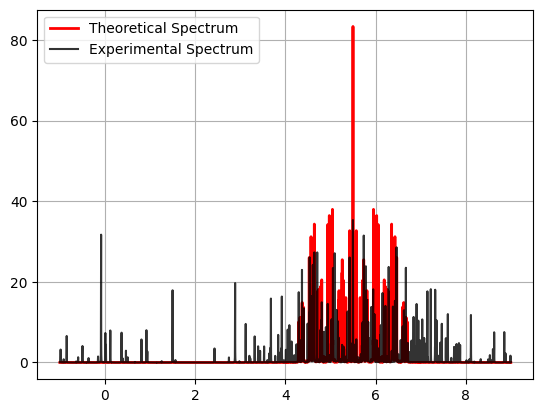

In [12]:
# Representamos ambos espectros para comparar.
mC.reprSpectrum(spcOut, fs, spcOutteo, fsteo)

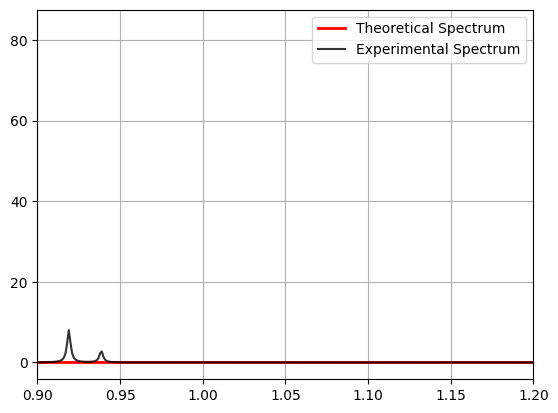

In [13]:
# Representamos ambos espectros para comparar.
mC.reprSpectrum(spcOut, fs, spcOutteo, fsteo,xlim=[0.9,1.2])

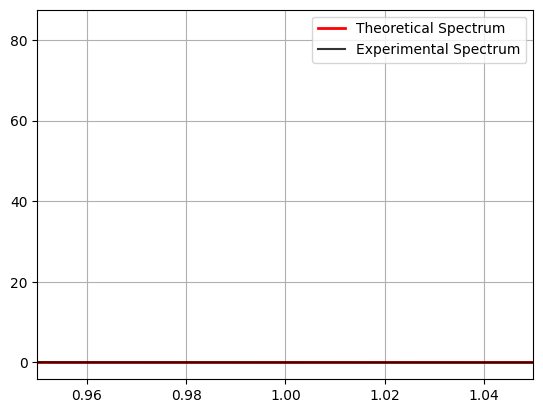

In [14]:
mC.reprSpectrum(spcOut, fs, spcOutteo, fsteo,xlim=[0.95,1.05])

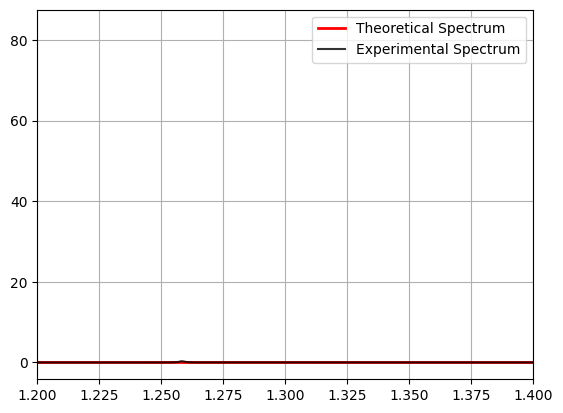

In [15]:
mC.reprSpectrum(spcOut, fs, spcOutteo, fsteo,xlim=[1.2,1.4])

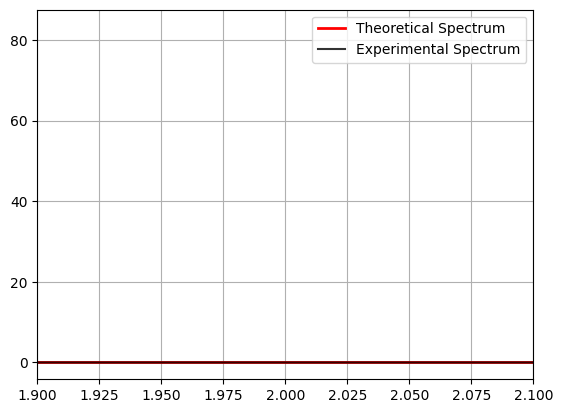

In [16]:
mC.reprSpectrum(spcOut, fs, spcOutteo, fsteo,xlim=[1.9,2.1])

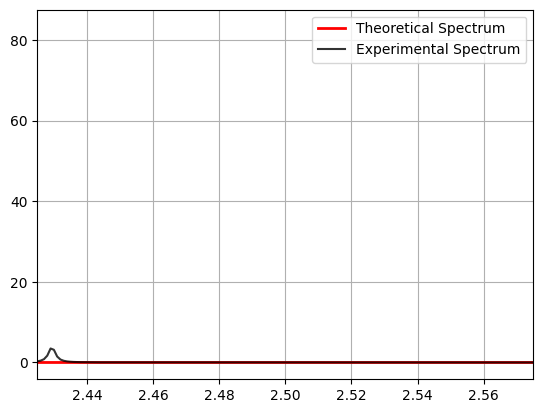

In [17]:
mC.reprSpectrum(spcOut, fs, spcOutteo, fsteo,xlim=[2.425,2.575])